#### 1) Problem definition
    Predict whether or not customer is interested for the Credit Card
#### 2) Data
    Data from https://datahack.analyticsvidhya.com/contest/job-a-thon-2/#ProblemStatement
        1. Variable
        2. ID
        3. Gender
        4. Age
        5. Region_Code
        6. Occupation
        7. Channel_Code
        8. Vintage
        9. Credit_Product
        10. Avg_Account_Balance
        11. Is_Active
        12. Is_Lead(Target)

    
#### 3) Evaluation
    If we can reach ROC Score of 0.88 at predicting whether or not a customer is interested in the Credit Card during the proof of concept, we'll pursue the project
    


### 1) Import tools

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [5]:
from lightgbm import LGBMClassifier

### 2) Get Data

In [6]:
train = pd.read_csv('/content/drive/MyDrive/Data Science Projects/Credit Card Lead Prediction/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Data Science Projects/Credit Card Lead Prediction/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/Data Science Projects/Credit Card Lead Prediction/sample_submission.csv')


In [7]:
train.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead'],
      dtype='object')

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [9]:
train.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,46.959141,1.128403e+06,0.237208
std,14.828672,32.353136,8.529364e+05,0.425372
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


In [10]:
train["Is_Lead"].value_counts()


0    187437
1     58288
Name: Is_Lead, dtype: int64

In [11]:
train["Is_Lead"].value_counts(normalize= True)

0    0.762792
1    0.237208
Name: Is_Lead, dtype: float64

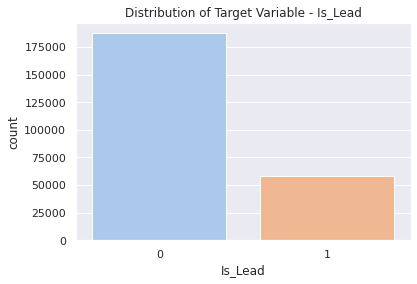

In [12]:
sns.set(style="darkgrid")
sns.countplot(train["Is_Lead"], palette = "pastel").set_title("Distribution of Target Variable - Is_Lead");

In [13]:
train.isnull().sum()/245725*100 ## 12% data missing

ID                      0.000000
Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Credit_Product         11.934073
Avg_Account_Balance     0.000000
Is_Active               0.000000
Is_Lead                 0.000000
dtype: float64

### 3) EDA

##### As we can see from the countplot, the distribution of the target variable (Is_Lead) is unbalanced [76:23]. 

There is a bias towards class '0', which is to say that our model may have a poor predictive power for the minority class '1', if not handled.

To handle this issue, I have tried a number of techniques, I tried creating synthetic samples using SMOTE so somewhat balance the 2 classes

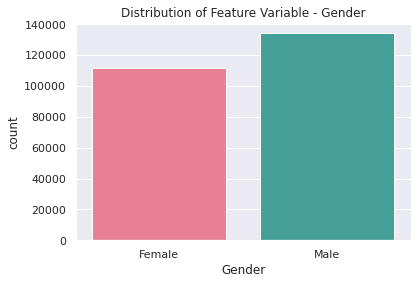

In [14]:
sns.countplot(train["Gender"], palette = "husl").set_title("Distribution of Feature Variable - Gender");

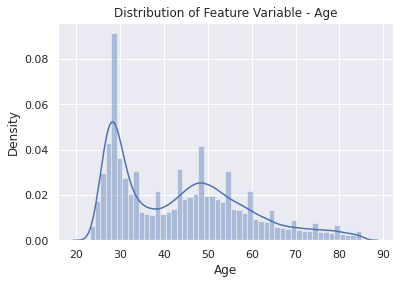

In [15]:
sns.distplot(train["Age"]).set_title("Distribution of Feature Variable - Age");

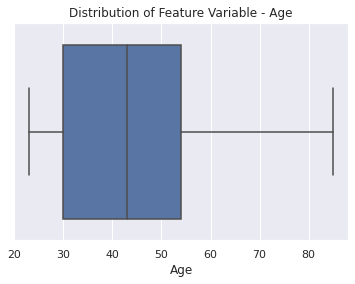

In [16]:
sns.boxplot(train["Age"]).set_title("Distribution of Feature Variable - Age");

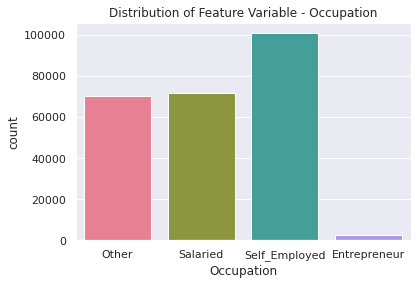

In [17]:
sns.countplot(train["Occupation"], palette = "husl").set_title("Distribution of Feature Variable - Occupation");

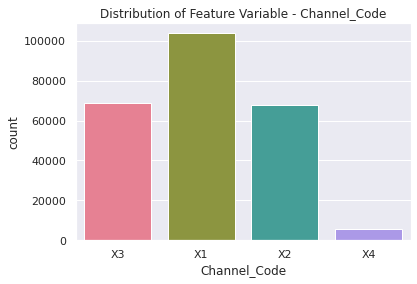

In [18]:
sns.countplot(train["Channel_Code"], palette = "husl").set_title("Distribution of Feature Variable - Channel_Code");

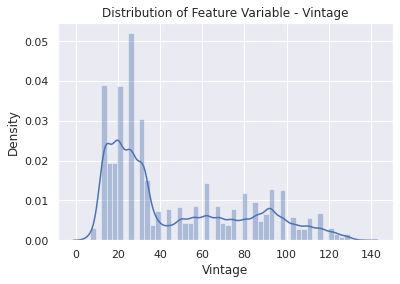

In [19]:
sns.distplot(train["Vintage"]).set_title("Distribution of Feature Variable - Vintage");

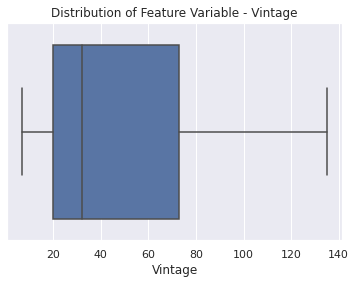

In [20]:
sns.boxplot(train["Vintage"]).set_title("Distribution of Feature Variable - Vintage");

No     0.667084
Yes    0.332916
Name: Credit_Product, dtype: float64


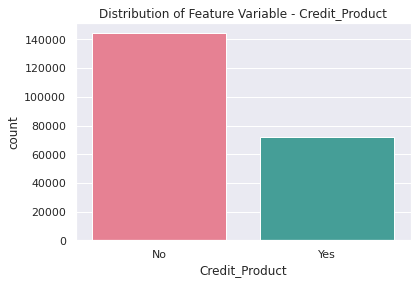

In [21]:
print(train["Credit_Product"].value_counts(normalize= True))
sns.countplot(train["Credit_Product"], palette = "husl").set_title("Distribution of Feature Variable - Credit_Product");

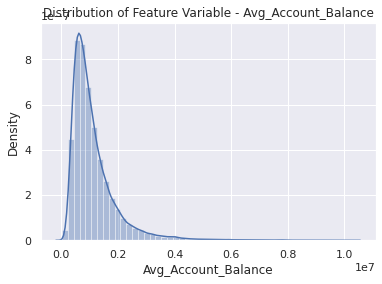

In [22]:
sns.distplot(train["Avg_Account_Balance"]).set_title("Distribution of Feature Variable - Avg_Account_Balance");

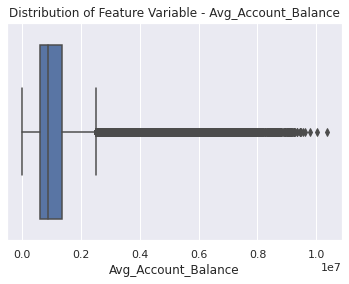

In [23]:
sns.boxplot(train["Avg_Account_Balance"]).set_title("Distribution of Feature Variable - Avg_Account_Balance");

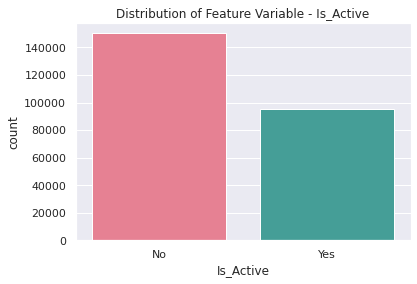

In [24]:
sns.countplot(train["Is_Active"], palette = "husl").set_title("Distribution of Feature Variable - Is_Active");

(4.5, -0.5)

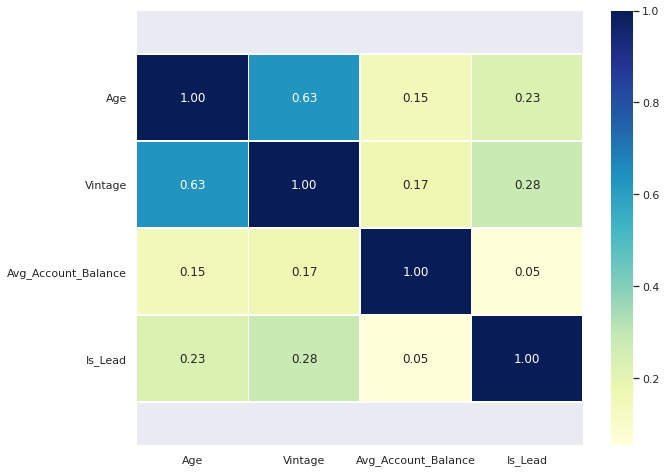

In [26]:
corr_matrix = train.corr()
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix,annot=True,linewidths=0.5,fmt=".2f",cmap="YlGnBu"); 
bottom, top = ax.get_ylim() 
ax.set_ylim(bottom + 0.5, top - 0.5)

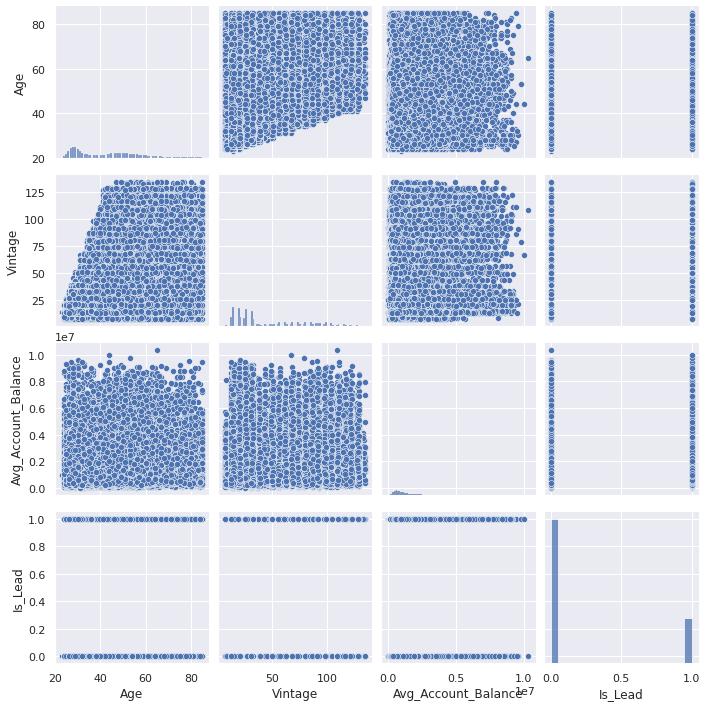

In [27]:
sns.pairplot(train)

### 4) Preprocessing

Steps to consider while processing our data:
1. Handle Missing Data
    We ended up using the LGBMClassifier,which handles the missing values by default
2. Convert to numerical
    Done using One Hot Encoder, since all our catergorical columns had nominal values (meaning they cannot be ordered in any meaningful way)
3. Transformations where required
    1. ["Age"] was a bimodal column, we could consider transforming the data => [abs(binomial - mean(binomial))].
    2. ["Avg_Account_Balance"] is skewed right. We could use the following transformation => np.log(X["Avg_Account_Balance"])
4. Discretization (If required)
    Considered using for "Avg_Account_Balance" to handle outliers
5. Handle Outliers
    Considered discretization for "Avg_Account_Balance" to handle outliers
6. Feature Scaling

In [28]:
X = train.drop(["ID","Is_Lead"], axis = 1) # Features
y = train["Is_Lead"] #target
test = test.drop(["ID"], axis = 1) # features from Test set

In [29]:
# convert categorical to numerical using One Hot Encoder
var_mod = ['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']
X = pd.get_dummies(X, columns=var_mod)
test = pd.get_dummies(test, columns=var_mod)

### 5) Evaluate model

##### We are using Stratified KFold cross validation to preserve the class distribution in out unbalanced dataset.

In [30]:
def cross_val(X, y, model, params, folds=9):

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=21)
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"Fold: {fold}")
        x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        alg = model(**params)
        alg.fit(x_train, y_train,
                eval_set=[(x_test, y_test)],
                early_stopping_rounds=100,
                verbose=400)

        pred = alg.predict_proba(x_test)[:, 1]
        roc_score = roc_auc_score(y_test, pred)
        print(f"roc_auc_score: {roc_score}")
        print("-"*50)
    
    return alg

In [34]:
lgb_params= {'learning_rate': 0.045, 
             'n_estimators': 20000, 
             'max_bin': 94,
             'num_leaves': 10, 
             'max_depth': 27, 
             'reg_alpha': 8.457, 
             'reg_lambda': 6.853, 
             'subsample': 0.749}

In [35]:
from lightgbm import LGBMClassifier
lgb_model = cross_val(X, y, LGBMClassifier, lgb_params)

Fold: 0
Training until validation scores don't improve for 100 rounds.
[400]	valid_0's binary_logloss: 0.341183
Early stopping, best iteration is:
[636]	valid_0's binary_logloss: 0.34103
roc_auc_score: 0.8760074575950891
--------------------------------------------------
Fold: 1
Training until validation scores don't improve for 100 rounds.
[400]	valid_0's binary_logloss: 0.347843
Early stopping, best iteration is:
[666]	valid_0's binary_logloss: 0.347707
roc_auc_score: 0.8717499619575518
--------------------------------------------------
Fold: 2
Training until validation scores don't improve for 100 rounds.
[400]	valid_0's binary_logloss: 0.34614
Early stopping, best iteration is:
[586]	valid_0's binary_logloss: 0.346061
roc_auc_score: 0.8708330618487019
--------------------------------------------------
Fold: 3
Training until validation scores don't improve for 100 rounds.
[400]	valid_0's binary_logloss: 0.346147
Early stopping, best iteration is:
[539]	valid_0's binary_logloss: 0.34

### 6) Final Submission

In [36]:
pred_test = lgb_model.predict_proba(test)[:,1]
sample_submission['Is_Lead'] = pred_test
sample_submission.to_csv('/content/drive/MyDrive/Data Science Projects/Credit Card Lead Prediction/submission.csv',index=False)

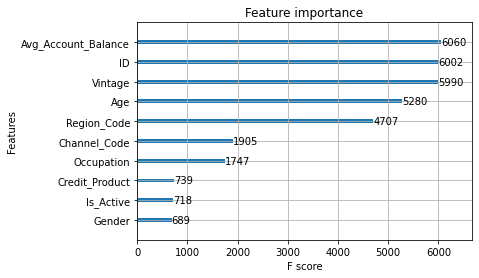

##### Avg acc balance helps determine who would be more inclined towards using credit cards 
##### Region Code signifies that some regions are considerably well off, indicating a higher concentration of credit card holders

### 7) Future Work
 

1. Feature Engineering using the more important features 
2. SMOTE with minority sampling to create synthectic datapoints
3. Feature selection  
4. Ensemble of different boosting techniques
  1. Cat boost -- categorical features
  2. Extreme gradient boosting